In [17]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "PhiUSIIL_Phishing_URL_Dataset.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ndarvind/phiusiil-phishing-url-dataset",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/var/folders/b1/9mxt04xj57qg0q48b2b677cm0000gn/T/ipykernel_48698/4118202117.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:                                   URL  URLLength                      Domain  \
0    https://www.southbankmosaics.com         31    www.southbankmosaics.com   
1            https://www.uni-mainz.de         23            www.uni-mainz.de   
2      https://www.voicefmradio.co.uk         29      www.voicefmradio.co.uk   
3         https://www.sfnmjournal.com         26         www.sfnmjournal.com   
4  https://www.rewildingargentina.org         33  www.rewildingargentina.org   

   DomainLength  IsDomainIP  TLD  URLSimilarityIndex  CharContinuationRate  \
0            24           0  com               100.0              1.000000   
1            16           0   de               100.0              0.666667   
2            22           0   uk               100.0              0.866667   
3            19           0  com               100.0              1.000000   
4            26           0  org               100.0              1.000000   

   TLDLegitimateProb  URLCharProb

In [18]:
# Print all column names in the DataFrame
print("Column names:")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")

# Display the shape of the DataFrame
print("\nDataFrame shape:", df.shape)

# Display basic information about the dataset
print("\nData types:")
print(df.dtypes)

# Check class distribution
print("\nLabel distribution:")
print(df['label'].value_counts())

Column names:
0: URL
1: URLLength
2: Domain
3: DomainLength
4: IsDomainIP
5: TLD
6: URLSimilarityIndex
7: CharContinuationRate
8: TLDLegitimateProb
9: URLCharProb
10: TLDLength
11: NoOfSubDomain
12: HasObfuscation
13: NoOfObfuscatedChar
14: ObfuscationRatio
15: NoOfLettersInURL
16: LetterRatioInURL
17: NoOfDegitsInURL
18: DegitRatioInURL
19: NoOfEqualsInURL
20: NoOfQMarkInURL
21: NoOfAmpersandInURL
22: NoOfOtherSpecialCharsInURL
23: SpacialCharRatioInURL
24: IsHTTPS
25: LineOfCode
26: LargestLineLength
27: HasTitle
28: Title
29: DomainTitleMatchScore
30: URLTitleMatchScore
31: HasFavicon
32: Robots
33: IsResponsive
34: NoOfURLRedirect
35: NoOfSelfRedirect
36: HasDescription
37: NoOfPopup
38: NoOfiFrame
39: HasExternalFormSubmit
40: HasSocialNet
41: HasSubmitButton
42: HasHiddenFields
43: HasPasswordField
44: Bank
45: Pay
46: Crypto
47: HasCopyrightInfo
48: NoOfImage
49: NoOfCSS
50: NoOfJS
51: NoOfSelfRef
52: NoOfEmptyRef
53: NoOfExternalRef
54: label

DataFrame shape: (235795, 55)

Dat

# Phishing URL Detection - Feature Analysis First Approach

In this notebook, we'll analyze a dataset of URLs to identify which features are most effective for distinguishing between legitimate and phishing URLs. Only after determining the important features will we build our model.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set random seed for reproducibility
np.random.seed(42)

## 1. Exploring the Dataset

Let's start by exploring the dataset to understand what features we have and how they're distributed.

In [20]:
# First, let's look at the dataset shape and how many samples we have
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")
print(f"Number of samples: {df.shape[0]}")

# Check for missing values
missing_values = df.isnull().sum()
print("\nFeatures with missing values:")
print(missing_values[missing_values > 0])

# Check class balance
print("\nClass distribution:")
print(df['label'].value_counts())
print(f"Percentage of legitimate URLs: {df['label'].mean()*100:.2f}%")

Dataset shape: (235795, 55)
Number of features: 54
Number of samples: 235795

Features with missing values:
Series([], dtype: int64)

Class distribution:
label
1    134850
0    100945
Name: count, dtype: int64
Percentage of legitimate URLs: 57.19%


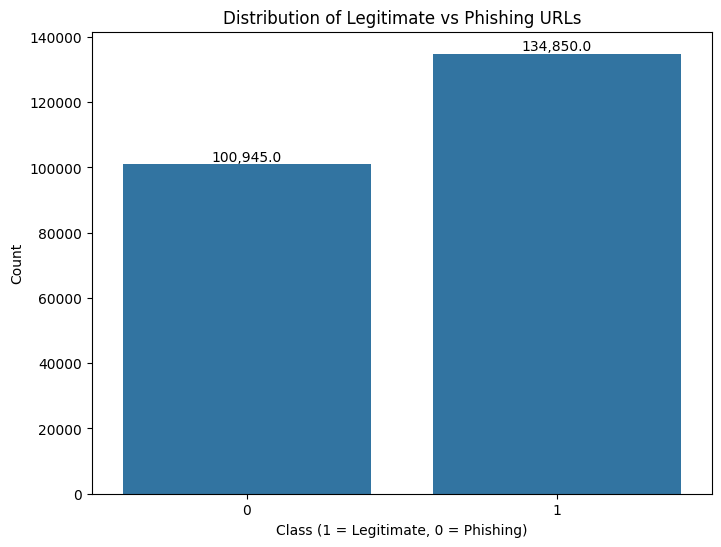

In [21]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df)
plt.title('Distribution of Legitimate vs Phishing URLs')
plt.xlabel('Class (1 = Legitimate, 0 = Phishing)')
plt.ylabel('Count')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom')
plt.show()

## 2. Detailed Feature Analysis

Let's analyze each feature in detail to understand its distribution and relationship with the target variable.

In [22]:
# List of all features (excluding the URL itself and the label)
features = [col for col in df.columns if col not in ['URL', 'label']]
print(f"Total number of features to analyze: {len(features)}")

# Let's create a function to analyze features in batches
def analyze_feature_batch(feature_batch, df, rows=3, cols=3):
    """Create histograms for a batch of features, split by class"""
    plt.figure(figsize=(18, 5*rows))
    for i, feature in enumerate(feature_batch):
        if i < rows*cols:
            plt.subplot(rows, cols, i+1)
            try:
                sns.histplot(data=df, x=feature, hue='label', bins=30, kde=True)
                plt.title(f'Distribution of {feature} by class')
            except Exception as e:
                print(f"Error plotting {feature}: {e}")
    plt.tight_layout()
    plt.show()

Total number of features to analyze: 53


In [ ]:
# Let's analyze URL-related features first (batch 1)
url_features = [col for col in features if 'URL' in col or 'Domain' in col or 'TLD' in col]
print("URL-related features:")
print(url_features)
analyze_feature_batch(url_features, df)

URL-related features:
['URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'NoOfURLRedirect']


In [ ]:
# Analyze character-related features (batch 2)
char_features = [col for col in features if 'Char' in col or 'Letter' in col or 'Degit' in col or 'Special' in col]
print("Character-related features:")
print(char_features)
analyze_feature_batch(char_features, df)

In [ ]:
# Analyze web page content-related features (batch 3)
page_features = [col for col in features if col not in url_features + char_features]
print("Web page content-related features:")
print(page_features)
analyze_feature_batch(page_features, df, rows=5, cols=4)

## 3. Feature Correlation Analysis

Let's identify which features are most correlated with our target variable (label) and examine relationships between features.

In [ ]:
# Calculate correlation with the target variable
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlations = df[numeric_features].corr()['label'].drop('label')

# Display top positive and negative correlations
print("Features most positively correlated with legitimate URLs:")
print(correlations.sort_values(ascending=False).head(10))
print("\nFeatures most negatively correlated with legitimate URLs (i.e., indicators of phishing):")
print(correlations.sort_values().head(10))

# Visualize the correlations
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations.sort_values(ascending=False).head(15).values, 
            y=correlations.sort_values(ascending=False).head(15).index)
plt.title('Top 15 Features Correlated with Legitimate URLs')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x=correlations.sort_values().head(15).values, 
            y=correlations.sort_values().head(15).index)
plt.title('Top 15 Features Correlated with Phishing URLs')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the correlation matrix for a subset of important features
important_features = list(correlations.abs().sort_values(ascending=False).head(15).index)
important_features.append('label')  # Add the target variable

# Create a correlation heatmap
plt.figure(figsize=(14, 12))
important_corr = df[important_features].corr()
sns.heatmap(important_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top Features')
plt.tight_layout()
plt.show()

## 4. Feature Importance Using Statistical Methods

Let's further analyze feature importance using statistical methods to understand which features are most discriminative for our classification task.

In [ ]:
# Prepare data for feature selection
X = df.drop(['URL', 'label'], axis=1)
y = df['label']

# Apply ANOVA F-test (works well for classification tasks)
f_test = SelectKBest(f_classif, k='all')
f_test.fit(X, y)

# Get and display feature scores
f_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_score': f_test.scores_,
    'p_value': f_test.pvalues_
}).sort_values('F_score', ascending=False)

print("Top 15 features based on ANOVA F-test:")
print(f_scores.head(15))

# Visualize feature importance scores
plt.figure(figsize=(12, 8))
sns.barplot(x='F_score', y='Feature', data=f_scores.head(20))
plt.title('Feature Importance from ANOVA F-test')
plt.tight_layout()
plt.show()

In [ ]:
# Apply Mutual Information (another method to measure feature relevance)
mi = SelectKBest(mutual_info_classif, k='all')
mi.fit(X, y)

# Get and display feature scores
mi_scores = pd.DataFrame({
    'Feature': X.columns,
    'MI_score': mi.scores_
}).sort_values('MI_score', ascending=False)

print("Top 15 features based on Mutual Information:")
print(mi_scores.head(15))

# Visualize feature importance scores
plt.figure(figsize=(12, 8))
sns.barplot(x='MI_score', y='Feature', data=mi_scores.head(20))
plt.title('Feature Importance from Mutual Information')
plt.tight_layout()
plt.show()

## 5. URL-Only Feature Subset Analysis

Given that our requirement is to classify URLs based only on the URL string (without accessing the webpage),
let's identify which URL-related features are available in this dataset and how effective they would be.

In [ ]:
# Define URL-only features (features that can be extracted from the URL string without visiting the webpage)
url_only_features = [
    'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex', 
    'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 
    'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 
    'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 
    'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 
    'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS'
]

# Check which features are actually available in our dataset
available_url_features = [f for f in url_only_features if f in df.columns]
print(f"Available URL-only features: {len(available_url_features)} out of {len(url_only_features)}")
print(available_url_features)

# Extract the subset for further analysis
url_features_df = df[available_url_features + ['label']]

In [ ]:
# Calculate correlation of URL-only features with the target
url_correlations = url_features_df.corr()['label'].drop('label')

# Display top positive and negative correlations
print("URL-only features most positively correlated with legitimate URLs:")
print(url_correlations.sort_values(ascending=False).head(10))
print("\nURL-only features most negatively correlated with legitimate URLs:")
print(url_correlations.sort_values().head(10))

# Visualize the correlations
plt.figure(figsize=(12, 8))
sns.barplot(x=url_correlations.abs().sort_values(ascending=False).values, 
            y=url_correlations.abs().sort_values(ascending=False).index)
plt.title('URL-Only Features Ranked by Correlation Strength with Target')
plt.xlabel('Absolute Correlation Coefficient')
plt.tight_layout()
plt.show()

## 6. Tree-Based Feature Importance

Let's use a tree-based method (Random Forest) to evaluate feature importance as it captures non-linear relationships.

In [ ]:
# Prepare URL-only feature data for Random Forest
X_url = url_features_df.drop(['label'], axis=1)
y_url = url_features_df['label']

# Pre-process: handle non-numeric columns if any
X_url_processed = pd.get_dummies(X_url)

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_url_processed, y_url)

# Get feature importances
rf_importances = pd.DataFrame({
    'Feature': X_url_processed.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 URL-only features based on Random Forest importance:")
print(rf_importances.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importances.head(15))
plt.title('URL-Only Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

## 7. Feature Selection for URL-Only Classification

Based on our analysis, let's select the most important URL-only features for our model.

In [ ]:
# Combine insights from correlation analysis and Random Forest importance
# Select top features from each method and combine them
top_corr_features = list(url_correlations.abs().sort_values(ascending=False).head(10).index)
top_rf_features = list(rf_importances.head(10)['Feature'])
                                          
# Combine unique features from both methods
selected_features = list(set(top_corr_features + top_rf_features))
print(f"Selected features for URL-only classification: {len(selected_features)}")
print(selected_features)

# Save these selected features for our model
selected_url_features = selected_features

## 8. Function to Extract URL Features

Now that we know which features are important, let's create a function to extract these features from a URL string.

In [ ]:
from urllib.parse import urlparse
import re

def extract_url_features(url):
    """Extract key features from a URL string based on our feature importance analysis"""
    
    # Parse the URL
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
    except:
        domain = ""
    
    # Basic URL features
    url_length = len(url)
    domain_length = len(domain)
    
    # TLD (Top-Level Domain)
    tld = ""
    if domain and "." in domain:
        tld = domain.split(".")[-1]
    tld_length = len(tld)
    
    # Count characters in URL
    letter_count = sum(c.isalpha() for c in url)
    letter_ratio = letter_count / url_length if url_length > 0 else 0
    
    digit_count = sum(c.isdigit() for c in url)
    digit_ratio = digit_count / url_length if url_length > 0 else 0
    
    special_chars = sum(not c.isalnum() for c in url)
    special_char_ratio = special_chars / url_length if url_length > 0 else 0
    
    # Special character counts
    equals_count = url.count('=')
    qmark_count = url.count('?')
    ampersand_count = url.count('&')
    other_special_chars = special_chars - (url.count('/') + equals_count + qmark_count + ampersand_count)
    
    # Subdomain analysis
    subdomain_count = domain.count('.') if domain else 0
    
    # Security indicators
    is_https = 1 if url.startswith("https://") else 0
    
    # Check if domain is an IP address
    ip_pattern = re.compile(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$')
    is_domain_ip = 1 if ip_pattern.match(domain) else 0
    
    # Return features as a dictionary
    features = {
        'URLLength': url_length,
        'DomainLength': domain_length,
        'TLDLength': tld_length,
        'NoOfLettersInURL': letter_count,
        'LetterRatioInURL': letter_ratio,
        'NoOfDegitsInURL': digit_count,
        'DegitRatioInURL': digit_ratio,
        'NoOfEqualsInURL': equals_count,
        'NoOfQMarkInURL': qmark_count, 
        'NoOfAmpersandInURL': ampersand_count,
        'NoOfOtherSpecialCharsInURL': other_special_chars,
        'SpacialCharRatioInURL': special_char_ratio,
        'IsHTTPS': is_https,
        'IsDomainIP': is_domain_ip,
        'NoOfSubDomain': subdomain_count
    }
    
    return features

## 9. Model Building with Selected Features

Now that we've identified the important features, let's build a model using only those features.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create dataset with only the selected features
X_selected = df[selected_url_features]
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model with the selected features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_prob = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of being legitimate

# Evaluate the model
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Fine-tune the model
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Use a smaller subset for grid search to save time
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_scaled, y_train, 
                                                        test_size=0.7, random_state=42, stratify=y_train)

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                          param_grid=param_grid, 
                          cv=3, 
                          n_jobs=-1,
                          scoring='accuracy')

grid_search.fit(X_train_sample, y_train_sample)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train the best model on the full training set
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Evaluate the best model
best_y_pred = best_model.predict(X_test_scaled)
print(f"\nTest accuracy with best model: {accuracy_score(y_test, best_y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, best_y_pred))

## 10. URL Classification Function

Now let's create a function that can classify a new URL as legitimate or phishing, using only URL-based features.

In [ ]:
def classify_url(url, model=best_model, scaler=scaler, selected_features=selected_url_features):
    """Classify a URL as legitimate (1) or phishing (0) using only URL-based features"""
    
    # Extract features from the URL
    features = extract_url_features(url)
    
    # Convert to DataFrame
    features_df = pd.DataFrame([features])
    
    # Select only the features used by the model
    # Handle any missing features that might not have been extracted
    missing_features = set(selected_features) - set(features_df.columns)
    for feature in missing_features:
        features_df[feature] = 0  # Default value
    
    features_df = features_df[selected_features]
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Make prediction
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0][1]  # Probability of being legitimate
    
    # Interpret result
    result = "Legitimate" if prediction == 1 else "Phishing"
    confidence = probability if prediction == 1 else 1 - probability
    
    return {
        "url": url,
        "prediction": int(prediction),
        "result": result,
        "confidence": confidence,
        "extracted_features": features
    }

In [ ]:
# Test the function with some example URLs
test_urls = [
    "https://www.google.com",
    "https://www.microsoft.com",
    "http://googl3-security.com",
    "http://paypal-secure.com.verification.login.asp",
    "https://github.com"
]

for url in test_urls:
    result = classify_url(url)
    print(f"URL: {url}")
    print(f"Prediction: {result['result']} (Confidence: {result['confidence']:.4f})")
    print("-" * 80)

## 11. Model Export

Finally, let's save our model and associated components for future use.

In [ ]:
import joblib

# Save the model and related objects
joblib.dump(best_model, 'phishing_detector_model.pkl')
joblib.dump(scaler, 'phishing_detector_scaler.pkl')
joblib.dump(selected_url_features, 'phishing_detector_features.pkl')

print("Model and related objects have been saved:")
print("- phishing_detector_model.pkl")
print("- phishing_detector_scaler.pkl")
print("- phishing_detector_features.pkl")

In [ ]:
# Example of how to load and use the saved model in a production environment
def load_phishing_detector():
    """Load the trained phishing detector model and related objects"""
    model = joblib.load('phishing_detector_model.pkl')
    scaler = joblib.load('phishing_detector_scaler.pkl')
    features = joblib.load('phishing_detector_features.pkl')
    return model, scaler, features

def predict_url(url, model=None, scaler=None, features=None):
    """Predict if a URL is phishing or legitimate using the saved model"""
    # Load model if not provided
    if model is None or scaler is None or features is None:
        model, scaler, features = load_phishing_detector()
    
    # Extract features
    url_features_dict = extract_url_features(url)
    features_df = pd.DataFrame([url_features_dict])
    features_df = features_df[features]  # Ensure correct order
    
    # Scale and predict
    features_scaled = scaler.transform(features_df)
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0][1]
    
    return {
        "url": url,
        "is_legitimate": bool(prediction),
        "confidence": probability if prediction == 1 else 1 - probability
    }